In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import savemat
import matplotlib.pyplot as plt
from src.dataloader.transforms import BandPassFilter, Spline_interpolation
import wfdb
from collections import Counter

In [2]:
IN_DIR = "mimic"
OUT_BASE = "data"
OUT_SPLIT = "split_csvs"
OUT_ECGS = "processed_data"
DS_NAME = "Mimic"

MIMIC IV has the lead order ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

In [3]:
ECG_DIR = os.path.join(IN_DIR, "mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0")

## Label exploration

In [4]:
df = pd.read_csv(os.path.join(IN_DIR, "records_w_diag_icd10.csv"))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800035 entries, 0 to 800034
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   file_name                800035 non-null  object 
 1   study_id                 800035 non-null  int64  
 2   subject_id               800035 non-null  int64  
 3   ecg_time                 800035 non-null  object 
 4   ed_stay_id               184720 non-null  float64
 5   ed_hadm_id               125314 non-null  float64
 6   hosp_hadm_id             298258 non-null  float64
 7   ed_diag_ed               800035 non-null  object 
 8   ed_diag_hosp             800035 non-null  object 
 9   hosp_diag_hosp           800035 non-null  object 
 10  all_diag_hosp            800035 non-null  object 
 11  all_diag_all             800035 non-null  object 
 12  gender                   800035 non-null  object 
 13  age                      795546 non-null  float64
 14  anch

In [6]:
df_tmp = df[(df["fold"] != 19) & df["age"].notnull()].sort_values("ecg_time")

In [7]:
df_tmp.shape

(756203, 23)

In [8]:
df_train = df_tmp.groupby("subject_id").head(1).sample(frac=0.25)

Count labels inside the chosen sample

In [9]:
labels = {}
for row in df_train.itertuples():
    if len(row[12]) > 2:
        all_labels = [label.replace("'", "").strip() for label in row[12][1:-1].split(",")]
        study_id = row[2]
        labels[study_id] = [label for label in all_labels if (label.startswith("R00") or label.startswith("I"))]

In [10]:
label_cnt = Counter()
for v in labels.values():
    for vv in v:
        label_cnt[vv] += 1

In [11]:
label_cnt.most_common(210)[-10:]

[('I2111', 12),
 ('I69392', 12),
 ('I6322', 11),
 ('I468', 11),
 ('I629', 11),
 ('I088', 11),
 ('I798', 11),
 ('I824Z1', 11),
 ('I953', 11),
 ('I361', 10)]

In [12]:
len(label_cnt)

568

## Test

In [24]:
rd_record = wfdb.rdrecord(os.path.join(ECG_DIR, "files/p1000/p10000032/s40689238/40689238"))

In [25]:
rd_record.fs

500

In [26]:
xx = rd_record.p_signal

In [27]:
xx.shape

(5000, 12)

In [28]:
x = np.arange(xx.shape[0])

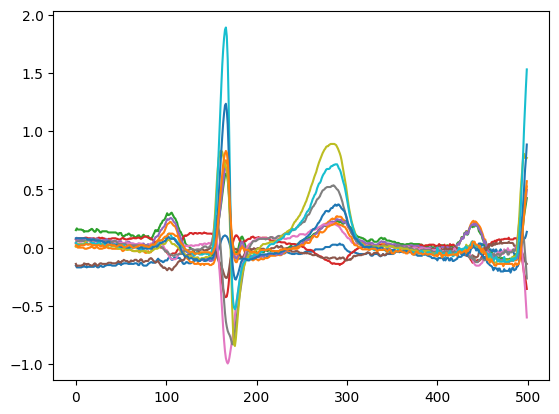

In [29]:
for j in range(xx.shape[-1]):
    plt.plot(x[:500], xx[:500,j])

In [31]:
bpf = BandPassFilter(fs=500)
ecg = bpf(xx.T)

In [32]:
ecg.shape

(12, 5000)

In [33]:
si = Spline_interpolation(fs_new=250, fs_old=500)
ecg = si(ecg)

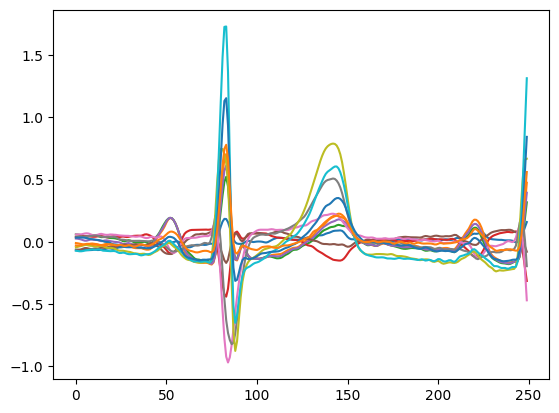

In [34]:
for j in range(ecg.shape[0]):
    plt.plot(x[:250], ecg[j, :250])

In [57]:
for row in df_train.itertuples():
    rd_record = wfdb.rdrecord(os.path.join(IN_DIR, row[1]))

    if np.isnan(ecg).any():
        print("bandpass", row[1])
        break
    ecg = si(ecg)
    if np.isnan(ecg).any():
        print("spline", row[1])
        break


## Class mappings

In [14]:
rename2snomed = {"I440": "270492004",
                 "I4510": "59118001",
                 "I447": "164909002",
                 "R001": "426177001",
                 "I4891": "164889003",
                 "R000": "427084000"}

In [15]:
pretrained_header = ['path', 'age', 'gender', 'fs',
              '426783006', '426177001', '164934002', '427393009',
              '713426002', '427084000', '59118001', '164889003',
              '59931005', '47665007', '445118002', '39732003',
              '164890007', '164909002', '270492004', '251146004', '284470004']

In [16]:
csv_header = ['path', 'age', 'gender', 'fs']

In [17]:
label_pos = {}
for i, (txt, _) in enumerate(label_cnt.most_common(200)):
    label_pos[txt] = i
    csv_header.append(txt)

Header for 200 class set

In [18]:
len(csv_header)

204

In [19]:
label_pos_pretrain = {}
rev_map = dict((v, k) for k, v in rename2snomed.items())
for i, label in enumerate(pretrained_header[4:]):
    if label in rev_map:
        label_pos_pretrain[rev_map[label]] = i

## Training set

In [20]:
df_train.shape

(37909, 23)

In [21]:
df_train.head()

,file_name,study_id,subject_id,ecg_time,ed_stay_id,ed_hadm_id,hosp_hadm_id,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,...,age,anchor_year,anchor_age,dod,ecg_no_within_stay,ecg_taken_in_ed,ecg_taken_in_hosp,ecg_taken_in_ed_or_hosp,fold,strat_fold
325535,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,44225542,14080900,2140-08-12 00:51:00,NaN,NaN,NaN,[],[],[],...,49.0,2140.0,49.0,NaN,-1,False,False,False,13,8
589837,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,48613925,17374087,2144-03-01 13:24:00,NaN,NaN,NaN,[],[],[],...,53.0,2142.0,51.0,2149-12-31,-1,False,False,False,5,13
270887,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,40511091,13397609,2184-11-19 13:58:00,NaN,NaN,NaN,[],[],[],...,74.0,2184.0,74.0,NaN,-1,False,False,False,1,5
488172,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,41680717,16084167,2188-07-22 09:21:00,NaN,NaN,NaN,[],[],[],...,58.0,2188.0,58.0,2188-08-11,-1,False,False,False,13,19
190204,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,44897187,12388817,2122-05-13 20:46:00,36976005.0,NaN,NaN,"['R002', 'R0602']",[],[],...,33.0,2122.0,33.0,NaN,0,True,False,True,4,9


In [22]:
mat_path = os.path.join(OUT_BASE, OUT_ECGS, DS_NAME)
os.makedirs(mat_path, exist_ok=True)

In [23]:
bpf = BandPassFilter(fs=500)
si = Spline_interpolation(fs_new=250, fs_old=500)

In [24]:
out_file = []
age_list = []
sex_list = []
nans = []
for row in df_train.itertuples():
    rd_record = wfdb.rdrecord(os.path.join(IN_DIR, row[1]))
    nans.append(np.isnan(rd_record.p_signal).sum())
    ecg = bpf(np.nan_to_num(rd_record.p_signal.T))
    #ecg = bpf(rd_record.p_signal.T)
    ecg = si(ecg)
    out_fn = os.path.join(mat_path, "{}.mat".format(row[2]))
    savemat(out_fn, {"val" : ecg})
    out_file.append(out_fn)
    age_list.append(int(row[14]))
    sex_list.append("Male" if row[13] == "M" else "Female")

In [25]:
out_file[:5]

['data/processed_data/Mimic/44225542.mat',
 'data/processed_data/Mimic/48613925.mat',
 'data/processed_data/Mimic/40511091.mat',
 'data/processed_data/Mimic/41680717.mat',
 'data/processed_data/Mimic/44897187.mat']

In [26]:
len(age_list)

37909

In [27]:
df_train["path"] = out_file
df_train["age"] = age_list
df_train["gender"] = sex_list
df_train["nans"] = nans

In [28]:
df_train["fs"] = 250

In [29]:
df_train = df_train[df_train["nans"] == 0]

In [30]:
df_train.shape

(37523, 26)

In [31]:
df_train = df_train.reset_index(drop=True)

In [32]:
df_train[["path", "age", "gender"]].head()

,path,age,gender
0,data/processed_data/Mimic/44225542.mat,49,Female
1,data/processed_data/Mimic/48613925.mat,53,Female
2,data/processed_data/Mimic/40511091.mat,74,Female
3,data/processed_data/Mimic/41680717.mat,58,Female
4,data/processed_data/Mimic/44897187.mat,33,Female


In [33]:
labels_lil = []
for row in df_train.itertuples():
    all_labels = [label.replace("'", "").strip() for label in row[12][1:-1].split(",")]
    labels_rec = [0] * 200
    for txt in all_labels:
        if txt in label_pos:
            labels_rec[label_pos[txt]] = 1
    labels_lil.append(labels_rec)


In [34]:
df2 = pd.DataFrame(np.array(labels_lil), columns=csv_header[4:])

In [35]:
df2.head()

,I10,I2510,I4891,I509,I129,R001,I252,I214,I959,R000,...,I776,I82890,I083,I2692,I6509,I6201,I6203,I318,I7411,I7409
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df2.sum()

I10      5859
I2510    2279
I4891    1766
I509     1053
I129      996
         ... 
I6201      12
I6203      12
I318       12
I7411      12
I7409      12
Length: 200, dtype: int64

In [37]:
df_200 = df_train.merge(df2, left_index=True, right_index=True)

In [38]:
csv_path = os.path.join(OUT_BASE, OUT_SPLIT, DS_NAME)
os.makedirs(csv_path, exist_ok=True)

In [40]:
df_200[csv_header].to_csv(os.path.join(csv_path, "ecgs_200classes.csv"), index=None, sep=',')

In [41]:
df_small = df_200.sample(frac=0.1)

In [42]:
df_small[csv_header].to_csv(os.path.join(csv_path, "ecgs_200classes_10.csv"), index=None, sep=',')

## MIMIC IV test fold

Dataset that is compatible with pretrained 17-class models
(classes have same column positions but may be 0-s if not present in Hefei)

In [43]:
DS_NAME = "Mimic_test"

In [44]:
mat_path = os.path.join(OUT_BASE, OUT_ECGS, DS_NAME)
os.makedirs(mat_path, exist_ok=True)

In [45]:
df_test = df[(df["fold"] == 19) & df["age"].notnull()]

In [46]:
df_test.shape

(39343, 23)

In [47]:
out_file = []
age_list = []
sex_list = []
nans = []
for row in df_test.itertuples():
    rd_record = wfdb.rdrecord(os.path.join(IN_DIR, row[1]))
    nans.append(np.isnan(rd_record.p_signal).sum())
    ecg = bpf(np.nan_to_num(rd_record.p_signal.T))
    #ecg = bpf(rd_record.p_signal.T)
    ecg = si(ecg)
    out_fn = os.path.join(mat_path, "{}.mat".format(row[2]))
    savemat(out_fn, {"val" : ecg})
    out_file.append(out_fn)
    age_list.append(int(row[14]))
    sex_list.append("Male" if row[13] == "M" else "Female")

In [50]:
len(nans)

39343

In [51]:
df_test2 = df_test.copy()

In [52]:
df_test2["path"] = out_file
df_test2["age"] = age_list
df_test2["gender"] = sex_list
df_test2["nans"] = nans
df_test2["fs"] = 250

In [53]:
df_test = df_test2[df_test2["nans"] == 0]

In [54]:
df_test.shape

(38819, 26)

In [55]:
labels_lil_pt = []
for row in df_test.itertuples():
    all_labels = [label.replace("'", "").strip() for label in row[12][1:-1].split(",")]
    labels_rec = [0] * 17
    for txt in all_labels:
        if txt in label_pos_pretrain:
            labels_rec[label_pos_pretrain[txt]] = 1
    labels_lil_pt.append(labels_rec)

In [56]:
df3 = pd.DataFrame(np.array(labels_lil_pt), columns=pretrained_header[4:])

In [57]:
df_test = df_test.reset_index(drop=True)

In [58]:
df_pt = df_test.merge(df3, left_index=True, right_index=True)

In [59]:
csv_path = os.path.join(OUT_BASE, OUT_SPLIT, DS_NAME)
os.makedirs(csv_path, exist_ok=True)

In [60]:
df_pt[pretrained_header].to_csv(os.path.join(csv_path, "ecgs_pretrained_compatible.csv"), index=None, sep=',')

In [61]:
df_small = df_pt.sample(frac=0.1)

In [62]:
df_small[pretrained_header].to_csv(os.path.join(csv_path, "ecgs_pretrained_compatible_10.csv"), index=None, sep=',')